# Match image to overlay

I tried to do some programmatic fitting, but ended up just manually guessing position of tip after applying canny edges.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
import imageio
from scipy import ndimage
from PIL import Image
import cv2

# Dev

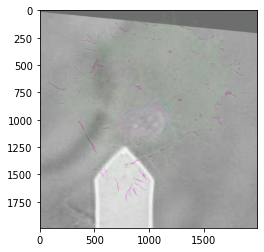

In [47]:
fname_confocal = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max.png')
fname_overlay_cyto = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max_overlay.cyto.png')
fname_overlay_nuc = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max_overlay.nucleus.png')

im1 = imageio.imread(fname_overlay_cyto)
im0 = imageio.imread(fname_confocal)

# print(im.shape)

plt.imshow(im0[:,:,:3]-im1[:,:,:3])
# plt.imshow()

In [22]:
im0.shape, im1.shape

((1988, 1988, 4), (1988, 1988, 4))

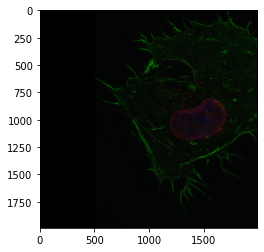

In [34]:
def roll_zeropad(a, shift, rot=0, axis=None):
    """
    Roll array elements along a given axis.

    Elements off the end of the array are treated as zeros.

    Parameters
    ----------
    a : array_like
        Input array.
    shift : int
        The number of places by which elements are shifted.
    axis : int, optional
        The axis along which elements are shifted.  By default, the array
        is flattened before shifting, after which the original
        shape is restored.

    Returns
    -------
    res : ndarray
        Output array, with the same shape as `a`.

    See Also
    --------
    roll     : Elements that roll off one end come back on the other.
    rollaxis : Roll the specified axis backwards, until it lies in a
               given position.

    """
    a = np.asanyarray(a)
    if shift == 0: return a
    if axis is None:
        n = a.size
        reshape = True
    else:
        n = a.shape[axis]
        reshape = False
    if np.abs(shift) > n:
        res = np.zeros_like(a)
    elif shift < 0:
        shift += n
        zeros = np.zeros_like(a.take(np.arange(n-shift), axis))
        res = np.concatenate((a.take(np.arange(n-shift,n), axis), zeros), axis)
    else:
        zeros = np.zeros_like(a.take(np.arange(n-shift,n), axis))
        res = np.concatenate((zeros, a.take(np.arange(n-shift), axis)), axis)
    if reshape:
        return res.reshape(a.shape)
    else:
        return res
    
def roll_2d(a, x=0, y=0):
    return roll_zeropad(roll_zeropad(a, x, 0), y, 1)

res = roll_2d(im0,0,500)
plt.imshow(res[:,:,:3])

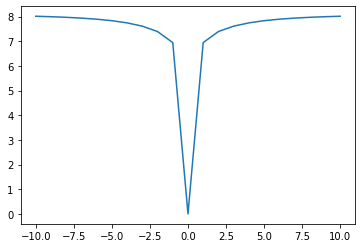

In [48]:
def loss_2d(im1, im2):
    return np.log10(1+np.sum((im1[:,:,:3]-im2[:,:,:3])**2))

losses_x = np.linspace(-10,10,21)
losses = [loss_2d(im0, roll_2d(im0, 0, int(x))) for x in losses_x ]
plt.plot(losses_x,losses)
    

In [47]:
# add rotation to shift
# define a transform which takes a list, and implements all 3
# Use an optimizer to fit
# Report results

array([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.])

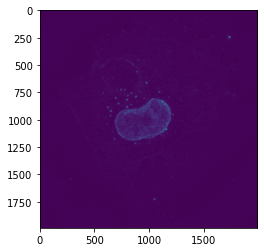

In [54]:

def rotateImage(img, angle):
    
    pivot = (img.shape[0]//2, img.shape[1]//2)
    padX = [img.shape[1] - pivot[0], pivot[0]]
    padY = [img.shape[0] - pivot[1], pivot[1]]
    imgP = np.pad(img, [padY, padX], 'constant')
    imgR = ndimage.rotate(imgP, angle, reshape=False)
    return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

plt.imshow(rotateImage(im0[:,:,0],0))


In [59]:
th = np.pi/180.0 * 10
tx = 10
ty = 0
T_rot = np.array([[np.cos(th), np.sin(th), 0], 
                [-np.sin(th), np.cos(th), 0], 
                [0, 0, 1]])

T_t = np.array([[1, 0, tx], 
                [0, 1, ty], 
                [0, 0, 1]])

T_tot = T_rot @ T_t

print(T_tot)

[[ 0.98480775  0.17364818  9.84807753]
 [-0.17364818  0.98480775 -1.73648178]
 [ 0.          0.          1.        ]]


In [61]:
plt.imshow(T_tot @ im0[:,:,0])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1988 is different from 3)

In [81]:
%%time
img = Image.open(fname_confocal)
img_npy = np.array(img)[:,:,:3]

T_inv = np.linalg.inv(T_tot)

img_transformed = img.transform(img.size, Image.AFFINE, data=T_inv.flatten()[:6], resample=Image.NEAREST)
# plt.imshow(np.asarray(img_transformed)[:,:,:3])

# plt.figure(figsize=(5, 5))
# plt.imshow(np.asarray(img)[:,:,:3])

CPU times: user 258 ms, sys: 14.9 ms, total: 273 ms
Wall time: 204 ms


CPU times: user 2.44 s, sys: 297 ms, total: 2.73 s
Wall time: 923 ms


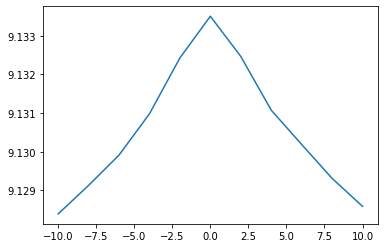

In [96]:
%%time 

def compare_images(im1, im2, params):
    tx, ty, th = params
    
    T_rot = np.array([[np.cos(th), np.sin(th), 0], 
                    [-np.sin(th), np.cos(th), 0], 
                    [0, 0, 1]])

    T_t = np.array([[1, 0, tx], 
                    [0, 1, ty], 
                    [0, 0, 1]])

    T_tot = T_rot @ T_t
    T_inv = np.linalg.inv(T_tot)

    
    im2 = Image.fromarray(im2)
    im2 = np.asarray(im2.transform(im2.size, Image.AFFINE, data=T_inv.flatten()[:6], resample=Image.NEAREST))
    
    loss = np.log10(1+np.sum((im1[:,:,:3]-im2[:,:,:3])**2))
    return loss

thx = np.linspace(-10*np.pi/180,10*np.pi/180,11)
thx = np.linspace(-10,10,11)
thy = [compare_images(im0,im1,(_,0,0)) for _ in thx]
plt.plot(thx, thy)


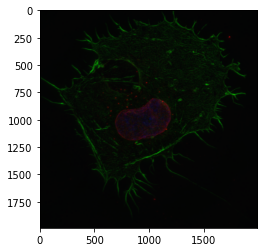

In [100]:
plt.imshow(im0)

# SIFT dev

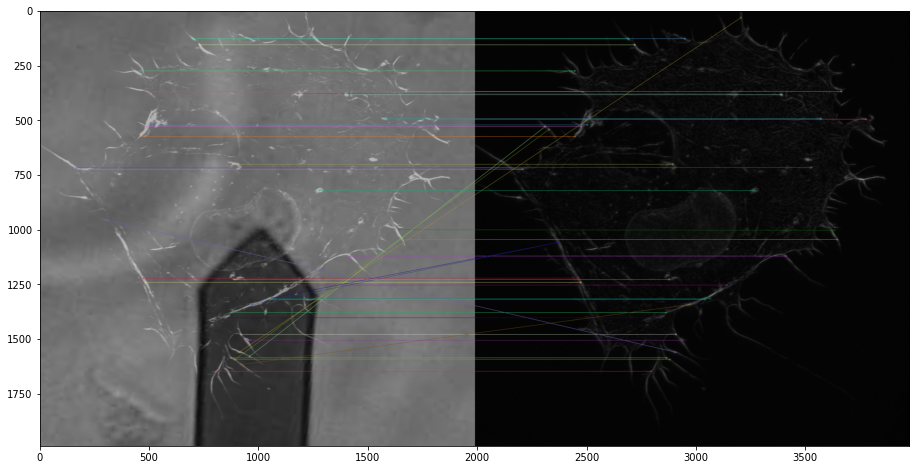

(<matplotlib.image.AxesImage at 0x12e3e17c0>, None)

In [48]:

import matplotlib.pyplot as plt
%matplotlib inline

# read images
img2 = cv2.imread(fname_confocal)  
# img1 = cv2.imread(fname_overlay_cyto) 
img1 = cv2.imread(fname_overlay_nuc) 



img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
fig = plt.figure(figsize=(16,8))
plt.imshow(img3),plt.show()

In [49]:
image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

for i in range(0,len(matches)):
    image_1_points[i] = keypoints_1[matches[i].queryIdx].pt
    image_2_points[i] = keypoints_2[matches[i].trainIdx].pt

cv2.findHomography(image_1_points,image_2_points, cv2.RANSAC)

(array([[ 9.99602752e-01, -2.90878070e-04,  3.97504462e-01],
        [ 2.16733858e-05,  9.99634379e-01, -5.73759665e-02],
        [-9.00745105e-08, -2.54012128e-07,  1.00000000e+00]]),
 array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [

'datasets/SR_HUVEC1/HUVEC Cell 1/srh1_1_max_overlay.nuc.png'

In [32]:
matches[0]

<DMatch 0x12defe830>

In [ ]:
# remaining:
# Make a template image for the pointer
# Ensure that I can extract position / rotation of the pointer
# Use this to extract final location of probing 

# Find tip alone

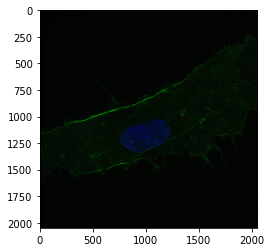

In [224]:
fname_confocal = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max.png')
fname_overlay_cyto = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max_overlay.cyto.png')
fname_overlay_nuc = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max_overlay.nucleus.png')
fname_tip = os.path.join('datasets/SR_HUVEC1/HUVEC AFM Brightfield XY','tip.png')

cell_n = 7
fname_confocal = os.path.join('datasets/SR_HUVEC1/HUVEC Cell %d/' % cell_n,'srh1_%d_max.png' % cell_n)
fname_overlay_cyto = os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','Cell %d Cytoplasm.png' % cell_n)
fname_overlay_nuc = os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','Cell %d Nucleus.png' % cell_n)
fname_tip = os.path.join('datasets/SR_HUVEC1/HUVEC AFM Brightfield XY','tip.png')


imtip = imageio.imread(fname_tip) 
im0 = imageio.imread(fname_overlay_cyto)
im1 = imageio.imread(fname_confocal)

# print(im.shape)

plt.imshow(im1[:,:,:3])
# plt.imshow()

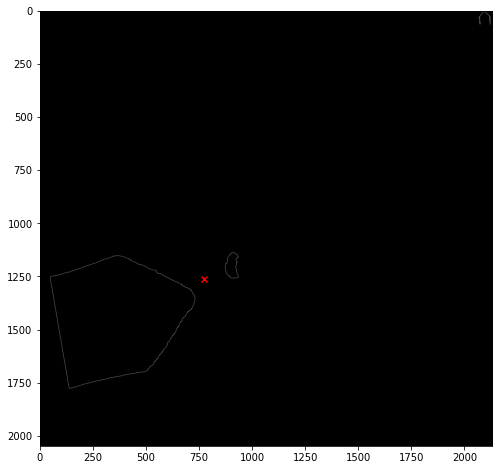

(<matplotlib.image.AxesImage at 0x1582740a0>, None)

In [225]:
img1 = cv2.imread(fname_overlay_cyto) 
img2 = cv2.imread(fname_tip) 

# img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img1 = img1[:,:,2]
#  ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV'][0]
img1 = cv2.threshold(img1,60,256,cv2.THRESH_BINARY)[1]

img2 = img2[:,:,2]
img2 = cv2.threshold(img2,60,256,cv2.THRESH_BINARY)[1]
# print(img1)


img1 = cv2.Canny(img1,10,20)
img2 = cv2.Canny(img2,50,100)

# t = [400,1100, 1100,1600]
# img1 = img1[t[2]:t[3],t[0]:t[1]]
# print(img1.shape)

#sift
sift = cv2.xfeatures2d.SIFT_create()
# sift = cv2.xfeatures2d.SIFT_create()
# surf = cv2.xfeatures2d.SURF_create()
# orb = cv2.ORB_create(nfeatures=1500)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:], img2, flags=2)
fig = plt.figure(figsize=(16,8))
plt.scatter(centered[0], centered[1], marker='x', color='red')
plt.imshow(img3),plt.show()

In [ ]:
##### image_1_points = np.zeros((len(matches), 1, 2), dtype=np.float32)
image_2_points = np.zeros((len(matches), 1, 2), dtype=np.float32)

for i in range(0,len(matches)):
    image_1_points[i] = keypoints_1[matches[i].queryIdx].pt
    image_2_points[i] = keypoints_2[matches[i].trainIdx].pt

tip_hom = cv2.findHomography(image_1_points,image_2_points, cv2.RANSAC)

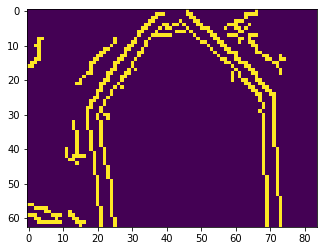

In [84]:
plt.imshow(img2)

In [87]:
np.linalg.inv( tip_hom[0]) @ np.array([[25],[25],[0]])

array([[-25166.64894623],
       [ -7692.68063611],
       [   -26.98109864]])

In [90]:
tip_hom[0] @ np.array([[750],[1259],[0]])

array([[-431.80828825],
       [ -86.87070111],
       [  -6.79663325]])

# By Eye

In [5]:
# Load and display an image
# Show canny edge and perceived edge
# Zoom in and show they are similar
# Repeat for all images
# import mplcursors

/Users/asears/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:114: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 1152x576 with 0 Axes>

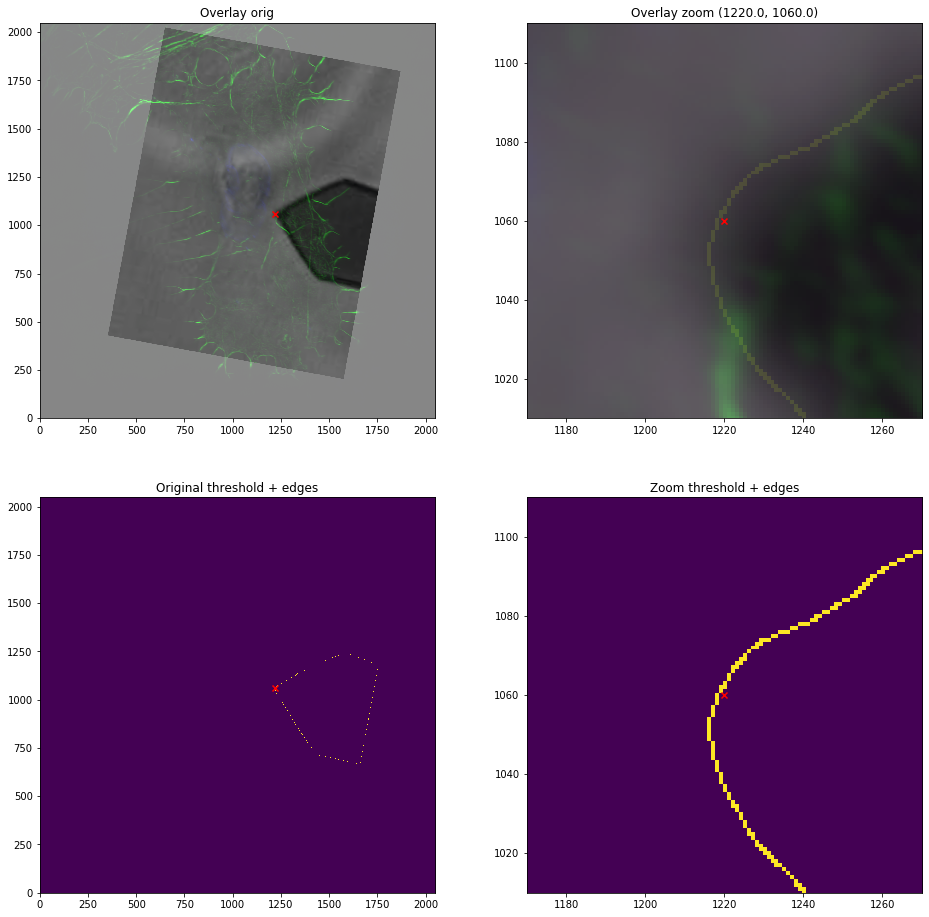

In [33]:
fname_confocal = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max.png')
fname_overlay_cyto = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max_overlay.cyto.png')
fname_overlay_nuc = os.path.join('datasets/SR_HUVEC1/HUVEC Cell 1/','srh1_1_max_overlay.nucleus.png')
fname_tip = os.path.join('datasets/SR_HUVEC1/HUVEC AFM Brightfield XY','tip.png')

view_types = ['Cytoplasm', 'Nucleus']

cell_n = 2
view_type = 0

fname_confocal = os.path.join('datasets/SR_HUVEC1/HUVEC Cell %d/' % cell_n,'srh1_%d_max.png' % cell_n)
fname_overlay_cyto = os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','Cell %d Cytoplasm.png' % cell_n)
fname_overlay_nuc = os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','Cell %d Nucleus.png' % cell_n)

fname_overlay_view = os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','Cell %d %s.png' % (cell_n, view_types[view_type]))

fname_tip = os.path.join('datasets/SR_HUVEC1/HUVEC AFM Brightfield XY','tip.png')


img1_orig = cv2.imread(fname_overlay_view) 

img1 = cv2.cvtColor(img1_orig, cv2.COLOR_BGR2GRAY)

# img1 = cv2.Canny(img1,10,20,100)
# img2 = cv2.Canny(img2,50,100)

fig = plt.figure(figsize=(16,8))

centered_all = [
            [
            (None, None, None),
            (773, 1250, 60),
            (1220, 1060, 60),
            (1175, 400, 60),
            (1122, 1367, 60),
            (1045, 967, 60),
            (1165, 1182, 60),
            (773, 1260, 60),
            ],
    
            [(None, None, None),
            (1010, 995, 60),
            (1037, 1050, 60),
            (1120, 745, 60),
            (1005, 1190, 60),
            (1010, 1335, 120),
            (1125, 925, 80),
            (900, 1257, 60),
            ]
           ]

np.save(os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','centered_all.npy'),centered_all)

centered = centered_all[view_type][cell_n]

t = (centered[0]-300, centered[0]+300, centered[1]-300, centered[1]+300)
# t = (400,1100,1600, 1100)
# t = (700,850, 1300, 1200)

# plt.xlim(t[0],t[1])
# plt.ylim(t[2],t[3])
# plt.scatter(centered[0], centered[1], marker='x', color='red')


if True:
    
    thresh_val = centered[2]
    
    # top left
    fig, ax = plt.subplots(2,2,figsize=(16,16))
    ax[0][0].imshow(img1_orig, origin='lower')
    ax[0][0].set_title('Overlay orig')
    ax[0][0].scatter(centered[0], centered[1], marker='x', color='red')


    
    # top right
    ax[0][1].imshow(img1_orig, origin='lower')
    ax[0][1].set_xlim(centered[0]-50, centered[0]+50)
    ax[0][1].set_ylim(centered[1]-50, centered[1]+50)
    ax[0][1].scatter(centered[0], centered[1], marker='x', color='red')
    
    ax[0][1].set_title('Overlay zoom (%0.1f, %0.1f)' % (centered[0], centered[1]))
    


    # bottom left
    
    img1 = img1_orig[:,:,2]
    #  ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV'][0]
    img1 = cv2.threshold(img1,thresh_val,256,cv2.THRESH_BINARY)[1]
    img1 = cv2.Canny(img1,10,20)

    ax[1][0].scatter(centered[0], centered[1], marker='x', color='red')
    ax[1][0].imshow(img1, origin='lower')

    ax[1][0].set_title('Original threshold + edges')

    
    
    # bottom right
    ax[1][1].imshow(img1)
    ax[1][1].set_xlim(centered[0]-50, centered[0]+50)
    ax[1][1].set_ylim(centered[1]-50, centered[1]+50)
    ax[1][1].scatter(centered[0], centered[1], marker='x', color='red')

    ax[1][1].set_title('Zoom threshold + edges')
    
    # overlay to top right
    ax[0][1].imshow(img1,alpha=0.1)

    fig.savefig(os.path.join('datasets/SR_HUVEC1/Overlay Images HUVEC/','Cell %d %s.composite.png' % (cell_n, view_types[view_type])),
                             bbox_inches = 'tight')
    fig.show()

    



In [29]:
%matplotlib inline

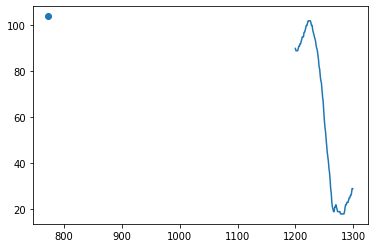

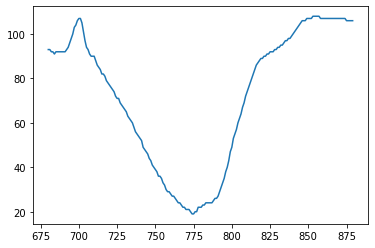

In [188]:
plt.plot(range(1200,1300), img1[1200:1300,780])
plt.scatter(centered[0], img1[centered[0],centered[1]])
plt.show()
plt.plot(range(680,880), img1[1270,680:880])
plt.show()


In [134]:
img1_crop = 

(1988, 1988)